<a href="https://colab.research.google.com/github/hopeffy/case-study-1-film-oneri-sistemi/blob/main/case_study_film_%C3%B6neri_sistemi_veri_bilimi_kul%C3%BCb%C3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

İlk hücrelerde gerekli kütüphaneleri yüklüyoruz: “Pandas”, “NumPy”, “SeaBorn” gibi veri işleme ve görselleştirme kütüphaneleri. Ardından iki “.csv” dosyası yükleniyor: "10000 Movies Data" ve "10000 Credits Data". Bu dosyaların içeriğinde “başlık”, “türler”, “bütçe”, “gelir”, “oy ortalaması” vb. filmlerle ilgili bilgiler ve “oyuncu kadrosu”, “yönetmen” gibi ek bilgiler bulunuyor.
Sonraki adımlarda veri ön işleme¹ yapıyoruz. Örneğin, “Budget”, “Revenue”, “poster_path” gibi gereksiz sütunlar çıkarılıyor. Tür bilgileri ayrıştırılarak “genre_name” ve “genre_id” sütunları oluşturuluyor. Yayın tarihinden “yıl” ve “on yıl” bilgisi çıkarılıyor. Ayrıca, “oy sayısı” ve “popülerlik” gibi sayısal değerler normalize² ediliyor.
Daha sonra, “özetler” ve “anahtar kelimeler” gibi metin verileri temizleniyor ve NLP³ teknikleri kullanılarak işleniyor. Bu işlemler arasında “tokenization”, “stopwords kaldırma”, “lemmatization” gibi adımlar var. Bu işlenmiş metinler, TF-IDF⁴ vektörlerine dönüştürülüyor ve benzerlik hesaplamaları için kullanılıyor.
Kullanıcıdan bir film adı ve tercihleri alınıyor. Bu tercihlere göre ağırlıklar belirleniyor ve bu ağırlıklar kullanılarak film özellikleri birleştiriliyor. Kosinüs benzerliği hesaplanarak en benzer filmler öneriliyor.

In [6]:
%pip install pandas
%pip install numpy

Farz olan kütüphaneleri import ediyoruz 🤝

In [7]:
import pandas as pd
import numpy as np

Öncelikle verilerimizi bir DataFrame objesine yüklüyoruz. İşlemlerimizi bu obje üstünden yürütmek, işlerimizi epey kolaylaştıracak.

In [8]:
data = pd.read_csv("10000 Movies Data.csv")
extra_columns = pd.read_csv("10000 Credits Data.csv", on_bad_lines='skip', engine='python')

Veri setimiz neye benziyor, bakalım.

In [9]:
display(data.head())
print("\n\n")
print(data.shape[0], data.shape[1])
print("\n\n")
data.info()

,index,Movie_id,title,Genres,release_date,Keywords,overview,poster_path,Budget,Revenue,popularity,vote_average,vote_count
0,0,238,The Godfather,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",1972-03-14,"[{'id': 131, 'name': 'italy'}, {'id': 697, 'na...","Spanning the years 1945 to 1955, a chronicle o...",/3bhkrj58Vtu7enYsRolD1fZdja1.jpg,245066411,245066411,93.552,8.7,16814
1,1,278,The Shawshank Redemption,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",1994-09-23,"[{'id': 378, 'name': 'prison'}, {'id': 417, 'n...",Framed in the 1940s for the double murder of h...,/q6y0Go1tsGEsmtFryDOJo3dEmqu.jpg,28341469,28341469,78.664,8.7,22542
2,2,240,The Godfather Part II,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",1974-12-20,"[{'id': 131, 'name': 'italy'}, {'id': 700, 'na...",In the continuing saga of the Corleone crime f...,/hek3koDUyRQk7FIhPXsa6mT2Zc3.jpg,102600000,102600000,55.752,8.6,10187
3,3,19404,Dilwale Dulhania Le Jayenge,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-10-19,[],"Raj is a rich, carefree, happy-go-lucky second...",/2CAL2433ZeIihfX1Hb2139CX0pW.jpg,100000000,100000000,22.150,8.6,3927
4,4,424,Schindler's List,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",1993-12-15,"[{'id': 818, 'name': 'based on novel or book'}...",The true story of how businessman Oskar Schind...,/sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg,321365567,321365567,53.542,8.6,13382





9980 13



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         9980 non-null   int64  
 1   Movie_id      9980 non-null   int64  
 2   title         9980 non-null   object 
 3   Genres        9980 non-null   object 
 4   release_date  9980 non-null   object 
 5   Keywords      9980 non-null   object 
 6   overview      9974 non-null   object 
 7   poster_path   9980 non-null   object 
 8   Budget        9980 non-null   int64  
 9   Revenue       9980 non-null   int64  
 10  popularity    9980 non-null   float64
 11  vote_average  9980 non-null   float64
 12  vote_count    9980 non-null   int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 1013.7+ KB


"Budget", "Revenue" ve "poster_path" bilgileri gereksiz durduğu için veri setimizden onları çıkarıyoruz.

In [10]:
data.drop(["Budget", "Revenue", "poster_path"], axis=1, inplace=True)
data.head()

,index,Movie_id,title,Genres,release_date,Keywords,overview,popularity,vote_average,vote_count
0,0,238,The Godfather,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",1972-03-14,"[{'id': 131, 'name': 'italy'}, {'id': 697, 'na...","Spanning the years 1945 to 1955, a chronicle o...",93.552,8.7,16814
1,1,278,The Shawshank Redemption,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",1994-09-23,"[{'id': 378, 'name': 'prison'}, {'id': 417, 'n...",Framed in the 1940s for the double murder of h...,78.664,8.7,22542
2,2,240,The Godfather Part II,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",1974-12-20,"[{'id': 131, 'name': 'italy'}, {'id': 700, 'na...",In the continuing saga of the Corleone crime f...,55.752,8.6,10187
3,3,19404,Dilwale Dulhania Le Jayenge,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-10-19,[],"Raj is a rich, carefree, happy-go-lucky second...",22.150,8.6,3927
4,4,424,Schindler's List,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",1993-12-15,"[{'id': 818, 'name': 'based on novel or book'}...",The true story of how businessman Oskar Schind...,53.542,8.6,13382


"Genres" sütunundaki verilere erişimi kolaylaştırmak adına bilgileri iki sütuna bölelim.

In [11]:
import ast

data["genre_name"] = None
data["genre_id"] = None

for i in range(data.shape[0]):
    if isinstance(data.at[i, "Genres"], str):
        genre_data = ast.literal_eval(data.at[i, "Genres"])
        names = [g["name"] for g in genre_data]
        ids = [g["id"] for g in genre_data]

        data.at[i, "genre_name"] = names
        data.at[i, "genre_id"] = ids

data.drop("Genres", axis=1, inplace=True)
data.head()

,index,Movie_id,title,release_date,Keywords,overview,popularity,vote_average,vote_count,genre_name,genre_id
0,0,238,The Godfather,1972-03-14,"[{'id': 131, 'name': 'italy'}, {'id': 697, 'na...","Spanning the years 1945 to 1955, a chronicle o...",93.552,8.7,16814,"[Drama, Crime]","[18, 80]"
1,1,278,The Shawshank Redemption,1994-09-23,"[{'id': 378, 'name': 'prison'}, {'id': 417, 'n...",Framed in the 1940s for the double murder of h...,78.664,8.7,22542,"[Drama, Crime]","[18, 80]"
2,2,240,The Godfather Part II,1974-12-20,"[{'id': 131, 'name': 'italy'}, {'id': 700, 'na...",In the continuing saga of the Corleone crime f...,55.752,8.6,10187,"[Drama, Crime]","[18, 80]"
3,3,19404,Dilwale Dulhania Le Jayenge,1995-10-19,[],"Raj is a rich, carefree, happy-go-lucky second...",22.150,8.6,3927,"[Comedy, Drama, Romance]","[35, 18, 10749]"
4,4,424,Schindler's List,1993-12-15,"[{'id': 818, 'name': 'based on novel or book'}...",The true story of how businessman Oskar Schind...,53.542,8.6,13382,"[Drama, History, War]","[18, 36, 10752]"


Değer atanmamış satır var mı diye bakalım.

In [12]:
display(data.isnull().sum())

,0
index,0
Movie_id,0
title,0
release_date,0
Keywords,0
overview,6
popularity,0
vote_average,0
vote_count,0
genre_name,0


NaN olmasa da boş olan satırlar da olabilir, teker teker kontrol edelim.

In [13]:
print(
    "Negatif index : " + f"{len([ i for i in data['index'] if i < 0 ])}\n" +

    "Negatif Movie_id : " + f"{len([ i for i in data['Movie_id'] if i < 0 ])}\n" +
    "Boş title : " + f"{len([ i for i in data['title'] if i == '' ])}\n" +
    "Boş genre_name : " + f"{len([ i for i in data['genre_name'] if i == list() ])}\n" +
    "Boş genre_id : " + f"{len([ i for i in data['genre_id'] if i == list() ])}\n" +
    "Boş release_date : " + f"{len([ i for i in data['release_date'] if i == '' ])}\n" +
    "Boş Keywords : " + f"{len([ i for i in data['Keywords'] if i == '' ])}\n" +
    "Boş overview : " + f"{len([ i for i in data['overview'] if i == '' ])}\n" +
    "Boş popularity : " + f"{len([ i for i in data['popularity'] if i == 0 ])}\n" +
    "Boş vote_average : " + f"{len([ i for i in data['vote_average'] if i == 0 ])}\n" +
    "Boş vote_count : " + f"{len([ i for i in data['vote_count'] if i == 0 ])}"
)

Negatif index : 0
Negatif Movie_id : 0
Boş title : 0
Boş genre_name : 2
Boş genre_id : 2
Boş release_date : 0
Boş Keywords : 0
Boş overview : 0
Boş popularity : 0
Boş vote_average : 0
Boş vote_count : 0


Aynı işlemleri bu ek veri setimiz için de yapıyoruz.

In [14]:
display(extra_columns.head())
print("\n\n")
print(extra_columns.shape[0], extra_columns.shape[1])
print("\n\n")
data.info()

,Unnamed: 0,Movie_id,title,Cast,Crew
0,0,238,The Godfather,"[{'adult': False, 'gender': 2, 'id': 3084, 'kn...","[{'adult': False, 'gender': 2, 'id': 154, 'kno..."
1,1,278,The Shawshank Redemption,"[{'adult': False, 'gender': 2, 'id': 504, 'kno...","[{'adult': False, 'gender': 2, 'id': 153, 'kno..."
2,2,240,The Godfather Part II,"[{'adult': False, 'gender': 2, 'id': 1158, 'kn...","[{'adult': False, 'gender': 2, 'id': 154, 'kno..."
3,3,19404,Dilwale Dulhania Le Jayenge,"[{'adult': False, 'gender': 2, 'id': 35742, 'k...","[{'adult': False, 'gender': 1, 'id': 8311, 'kn..."
4,4,424,Schindler's List,"[{'adult': False, 'gender': 2, 'id': 3896, 'kn...","[{'adult': False, 'gender': 2, 'id': 491, 'kno..."





9948 5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         9980 non-null   int64  
 1   Movie_id      9980 non-null   int64  
 2   title         9980 non-null   object 
 3   release_date  9980 non-null   object 
 4   Keywords      9980 non-null   object 
 5   overview      9974 non-null   object 
 6   popularity    9980 non-null   float64
 7   vote_average  9980 non-null   float64
 8   vote_count    9980 non-null   int64  
 9   genre_name    9980 non-null   object 
 10  genre_id      9980 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 857.8+ KB


In [15]:
display(extra_columns.isnull().sum())

,0
Unnamed: 0,0
Movie_id,0
title,0
Cast,0
Crew,0


In [16]:
# Bazı sütun verileri, liste veya sözlük türünde olmalarına rağmen
# muhtemelen depolamadan tasarruf amacıyla string türünde kaydedilmişler.
# Onları gerçek hâllerine çevirmek adına bu kütüphaneyi kullanacağız.

import ast

print(
    "Negatif Movie_id : " + f"{len([ i for i in extra_columns['Movie_id'] if i < 0 ])}\n" +
    "Boş title : " + f"{len([ i for i in extra_columns['title'] if i == '' ])}\n" +
    "Boş Cast : " + f"{len([ i for i in extra_columns['Cast'] if ast.literal_eval(i) == list() ])}\n" +
    "Boş Crew : " + f"{len([ i for i in extra_columns['Crew'] if ast.literal_eval(i) == list() ])}"
)


Negatif Movie_id : 0
Boş title : 0
Boş Cast : 16
Boş Crew : 0


Sırada feature engineering var. Elimizdeki bilgileri evirip çevirerek ileride kullanabileceğimiz bilgilere dönüştüreceğiz.

Burada, Crew listesindeki, her film için en popüler yönetmeni seçip onun id ve name bilgilerini alarak şimdi oluşturduğumuz data["director"] sütununa ekliyoruz.
Böylece, ileride film önerirken bir yönetmenin başka yapımlarına da göz atmak isteyecek kullanıcılara cevap verebiliriz.

In [17]:
def winnow(LIST):
    LIST = ast.literal_eval(LIST)

    max_dict = max(LIST, key=lambda x: x.get("popularity", float("-inf")))

    return { "id": max_dict["id"], "name": max_dict["name"].lower() }


data["director"] = extra_columns["Crew"].apply(winnow)

Şimdi de oyuncuları top_acts fonksiyonu ile popülerliklerine göre sıralayarak en popüler olanlardan ilk 5'ini alıp her birinin id ve name bilgilerini data["cast"] sütununa ekliyoruz.
Benzer şekilde, filmdeki bir veya birden fazla oyuncunun yer aldığı diğer filmleri de önerme şansı elde ediyoruz.

In [18]:
def top_acts(LIST, count=5):
    LIST = ast.literal_eval(LIST)
    LIST.sort(key=lambda x: x.get("popularity", float("-inf")))
    return [ { "id": i["id"], "name": i["name"].lower() } for i in LIST[:count] ]


data["cast"] = extra_columns["Cast"].apply(top_acts)

Artık ihtiycımız kalmayan veri setini silip çıkardığımız işe göz atıyoruz.

In [19]:
#del(extra_columns)

display(data["director"])
display(data["cast"])

,director
0,"{'id': 1776, 'name': 'francis ford coppola'}"
1,"{'id': 3027, 'name': 'stephen king'}"
2,"{'id': 3085, 'name': 'james caan'}"
3,"{'id': 35740, 'name': 'sharmishta roy'}"
4,"{'id': 488, 'name': 'steven spielberg'}"
...,...
9975,NaN
9976,NaN
9977,NaN
9978,NaN


,cast
0,"[{'id': 1394703, 'name': 'robert dahdah'}, {'i..."
1,"[{'id': 2772979, 'name': 'john e. summers'}, {..."
2,"[{'id': 1503034, 'name': 'nick discenza'}, {'i..."
3,"[{'id': 1661299, 'name': 'hemlata deepak'}, {'..."
4,"[{'id': 1592167, 'name': 'michael gordon'}, {'..."
...,...
9975,NaN
9976,NaN
9977,NaN
9978,NaN


"release_date" verileri de string hâlinde tutuluyor. Filmlerin çıkış yıllarına erişimi kolaylaştırmak adına ayrı bir sütun oluşturabiliriz.

In [20]:
for i in range(data.shape[0]):
    data.at[i, "release_year"] = int(data.at[i, "release_date"][:4])

data.head()

,index,Movie_id,title,release_date,Keywords,overview,popularity,vote_average,vote_count,genre_name,genre_id,director,cast,release_year
0,0,238,The Godfather,1972-03-14,"[{'id': 131, 'name': 'italy'}, {'id': 697, 'na...","Spanning the years 1945 to 1955, a chronicle o...",93.552,8.7,16814,"[Drama, Crime]","[18, 80]","{'id': 1776, 'name': 'francis ford coppola'}","[{'id': 1394703, 'name': 'robert dahdah'}, {'i...",1972.0
1,1,278,The Shawshank Redemption,1994-09-23,"[{'id': 378, 'name': 'prison'}, {'id': 417, 'n...",Framed in the 1940s for the double murder of h...,78.664,8.7,22542,"[Drama, Crime]","[18, 80]","{'id': 3027, 'name': 'stephen king'}","[{'id': 2772979, 'name': 'john e. summers'}, {...",1994.0
2,2,240,The Godfather Part II,1974-12-20,"[{'id': 131, 'name': 'italy'}, {'id': 700, 'na...",In the continuing saga of the Corleone crime f...,55.752,8.6,10187,"[Drama, Crime]","[18, 80]","{'id': 3085, 'name': 'james caan'}","[{'id': 1503034, 'name': 'nick discenza'}, {'i...",1974.0
3,3,19404,Dilwale Dulhania Le Jayenge,1995-10-19,[],"Raj is a rich, carefree, happy-go-lucky second...",22.150,8.6,3927,"[Comedy, Drama, Romance]","[35, 18, 10749]","{'id': 35740, 'name': 'sharmishta roy'}","[{'id': 1661299, 'name': 'hemlata deepak'}, {'...",1995.0
4,4,424,Schindler's List,1993-12-15,"[{'id': 818, 'name': 'based on novel or book'}...",The true story of how businessman Oskar Schind...,53.542,8.6,13382,"[Drama, History, War]","[18, 36, 10752]","{'id': 488, 'name': 'steven spielberg'}","[{'id': 1592167, 'name': 'michael gordon'}, {'...",1993.0


In [21]:

decade = [(int((year % 100) / 10) * 10) for year in data["release_year"]]
data["decade"] = decade

data.head()

,index,Movie_id,title,release_date,Keywords,overview,popularity,vote_average,vote_count,genre_name,genre_id,director,cast,release_year,decade
0,0,238,The Godfather,1972-03-14,"[{'id': 131, 'name': 'italy'}, {'id': 697, 'na...","Spanning the years 1945 to 1955, a chronicle o...",93.552,8.7,16814,"[Drama, Crime]","[18, 80]","{'id': 1776, 'name': 'francis ford coppola'}","[{'id': 1394703, 'name': 'robert dahdah'}, {'i...",1972.0,70
1,1,278,The Shawshank Redemption,1994-09-23,"[{'id': 378, 'name': 'prison'}, {'id': 417, 'n...",Framed in the 1940s for the double murder of h...,78.664,8.7,22542,"[Drama, Crime]","[18, 80]","{'id': 3027, 'name': 'stephen king'}","[{'id': 2772979, 'name': 'john e. summers'}, {...",1994.0,90
2,2,240,The Godfather Part II,1974-12-20,"[{'id': 131, 'name': 'italy'}, {'id': 700, 'na...",In the continuing saga of the Corleone crime f...,55.752,8.6,10187,"[Drama, Crime]","[18, 80]","{'id': 3085, 'name': 'james caan'}","[{'id': 1503034, 'name': 'nick discenza'}, {'i...",1974.0,70
3,3,19404,Dilwale Dulhania Le Jayenge,1995-10-19,[],"Raj is a rich, carefree, happy-go-lucky second...",22.150,8.6,3927,"[Comedy, Drama, Romance]","[35, 18, 10749]","{'id': 35740, 'name': 'sharmishta roy'}","[{'id': 1661299, 'name': 'hemlata deepak'}, {'...",1995.0,90
4,4,424,Schindler's List,1993-12-15,"[{'id': 818, 'name': 'based on novel or book'}...",The true story of how businessman Oskar Schind...,53.542,8.6,13382,"[Drama, History, War]","[18, 36, 10752]","{'id': 488, 'name': 'steven spielberg'}","[{'id': 1592167, 'name': 'michael gordon'}, {'...",1993.0,90


Veri setindeki vote_count ve popularity sütunlarının dağılımlarını görselleştirmek için histogramlar oluşturuyoruz.
Filmlerin "Engagement" değerlerini daha iyi anlamlandırmak adına her iki sütuna da log dönüşümü uygulayarak değerleri normalleştirip değerleri aynı ölçeğe indirgiyoruz.

Log dönüşümü, özellikle dağılımı çarpık (skewed) verilerde kullanılır. Özellikle çok büyük değerler arasındaki farkları küçültüp veri setindeki ekstrem değerlerin etkisi azaltılır.
Bu sayede daha anlamlı analizler ve görselleştirmeler yapılabilir.

Öncesi: 


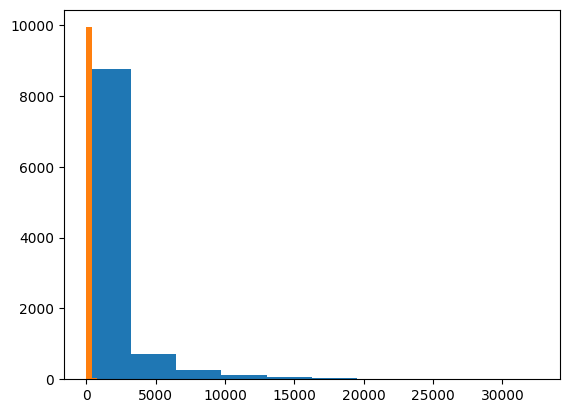

Sonrası: 


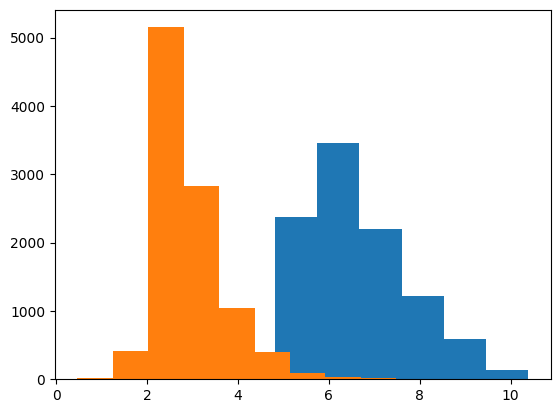

,title,normalised_vote_count,normalised_popularity
0,The Godfather,9.730027,4.549150
1,The Shawshank Redemption,10.023180,4.377818
2,The Godfather Part II,9.228966,4.038691
3,Dilwale Dulhania Le Jayenge,8.275886,3.141995
4,Schindler's List,9.501741,3.998971


In [22]:
import matplotlib.pyplot as plt

print("Öncesi: ")
plt.hist(data["vote_count"])
plt.hist(data["popularity"])
plt.show()

# Sıfır ve negatif değerlere karşı koruma işin log(1+x)
data["normalised_vote_count"] = np.log1p(data["vote_count"])
data["normalised_popularity"] = np.log1p(data["popularity"])

print("Sonrası: ")
plt.hist(data["normalised_vote_count"])
plt.hist(data["normalised_popularity"])
plt.show()

data[["title", "normalised_vote_count", "normalised_popularity"]].head()

Metin işleme ve anahtar kelime temizliği için kullanacağımız NLTK kütüphanesinden gerekli modülleri indirelim.

In [23]:
# ------------
# Keyword temizlemekte kullanılacak NLTK kütüphanesinden gereken modülleri indir
# Not: Sadece bir kere çalıştır(man yeterli)!
# ------------

import nltk

nltk.download('punkt')  # metni cümlelere ve kelimelere ayırmaya yardımcı
nltk.download('averaged_perceptron_tagger_eng') # metindeki kelimeleri türlerine göre etiketler (isim, fiil, sıfat vb.)
nltk.download('wordnet')    # kelimelerin anlamlarını ve eş anlamlılarını belirlemeye yardımcı
nltk.download('stopwords')  # metinlerde yaygın olarak bulunan, anlam taşımayan kelimeleri (“ve”, “bu”, “the”) çıkarır
nltk.download('punkt_tab') # punkt_tab paketini indir

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [24]:
# ---------------------------
# Gerekli kütüphaneleri import et
# ---------------------------
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

Elimizdeki POS (Part-Of-Speech) etiketini, etiketin baş harfine bakarak hangi tür kelime olduğunu belirleyelim ve WordNet lemmatizer’ının anlayabileceği formata çevirelim.

In [25]:
def get_wordnet_pos(treebank_tag):
    """POS etiketi WordNet lemmatizer'a uygun bir şekilde dönüştür."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Yukarıda bahsedilen işlemleri yapan fonksiyonu yazalım.

In [26]:
def preprocess_text(text):
    """Metni tokenize et, durdurma kelimelerini kaldır ve kök haline dönüştür."""
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    pos_tags = nltk.pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
    return " ".join(lemmatized)

In [27]:
# ---------------------------
# Genel Liste İşleme Fonksiyonu
# ---------------------------
def preprocess_list(column_value, key="name", max_items=None):
    """
    Genel liste sütunlarını işlemek için fonksiyon.
    :param column_value: İşlenecek sütun değeri.
    :param key: Sözlüklerde kullanılacak anahtar.
    :param max_items: Maksimum işlenecek öğe sayısı (örn. cast için ilk 5 oyuncu).
    """
    try:
        items = ast.literal_eval(column_value)
    except Exception:
        items = column_value
    if isinstance(items, list):
        items = [item[key].lower() for item in items if key in item]
        if max_items:
            items = items[:max_items]
        return " ".join(items)
    else:
        return str(items).lower()

In [28]:
# ---------------------------
# Veri Çerçevesini Hazırla
# ---------------------------
# Kritik bilgiler eksik olan satırları kaldır
data.dropna(subset=["overview", "Keywords", "genre_name", "cast", "release_year", "decade", "popularity"], inplace=True)

# Metin alanlarını ön işleme tabi tut
data["processed_overview"] = data["overview"].apply(preprocess_text)
data["processed_keywords"] = data["Keywords"].apply(preprocess_list)
data["processed_genres"] = data["genre_name"].apply(preprocess_list)
data["processed_cast"] = data["cast"].apply(lambda x: preprocess_list(x, max_items=5))


In [29]:
# ---------------------------
# Sayısal Alanları String'e Çevir
# ---------------------------
numeric_columns = ["release_year", "decade", "popularity"]
for col in numeric_columns:
    data[f"{col}_str"] = data[col].astype(str)

In [30]:
# ---------------------------
# Kullanıcıdan Tercihleri Al
# ---------------------------
def ask():
    """
    Kullanıcıdan sevdiği bir filmi ve bu filmde sevdiği özellikleri seçmesini iste.
    """
    title = input("\nBeğendiğiniz bir film adı girin: ")
    user_choices = input(""
    "Bu filmi özellikle neden beğendiğinizi bizimle paylaşın!\n"
    "Aşağıdaki özelliklerden hoşlandıklarınızı seçmek için numaralarını virgülle ayırarak girin:\n"
    " 1. Tür (Genre)\n"
    " 2. Yapım (Keywords)\n"
    " 3. Oyunculuk Performansı (Cast)\n"
    " 4. Dönem Havası (Yayın Yılı/On Yıl)\n"
    " 5. Genel Konu ve Hikâye Anlatımı (Overview)"
                         "Seçimleriniz (örn. 1,3,5): ")

    return title, user_choices

In [31]:
# ---------------------------
# Ağırlıkları Belirle
# ---------------------------
def get_weights_from_choices(user_choices):
    """
    Kullanıcının seçtiği özelliklere göre ağırlıkları ayarlar.
    """
    choices = [choice.strip() for choice in user_choices.split(",")]
    weights = {
        "overview": 1,
        "Keywords": 1,
        "genres": 1,
        "cast": 1,
        "release_year": 1,
        "decade": 1,
        "normalised_popularity": 1
    }

    if "1" in choices:  # Tür
        weights["genres"] += 2
    if "2" in choices:  # Anahtar kelimeler
        weights["Keywords"] += 2
    if "3" in choices:  # Oyuncular
        weights["cast"] += 2
    if "4" in choices:  # Yayın yılı/on yıl
        weights["release_year"] += 1
        weights["decade"] += 2
    if "5" in choices:  # Genel konu
        weights["overview"] += 1

    return weights

In [32]:
# ---------------------------
# Özellikleri Birleştir
# ---------------------------
def create_combined_features(row, weights):
    """
    Her film için, belirlenen ağırlıklara göre tüm özellikleri tek bir string halinde birleştirir.
    """
    features = (
        (row["processed_overview"] + " ") * weights["overview"] +
        (row["processed_keywords"] + " ") * weights["Keywords"] +
        (row["processed_genres"] + " ") * weights["genres"] +
        (row["processed_cast"] + " ") * weights["cast"] +
        (row["release_year_str"] + " ") * weights["release_year"] +
        (row["decade_str"] + " ") * weights["decade"] +
        (row["popularity_str"] + " ") * weights["normalised_popularity"]
    )
    return features

In [33]:
# ---------------------------
# Ana Öneri Fonksiyonu
# ---------------------------

def get_recommendations(title, user_choices, data, top_n=10):
    """
    Kullanıcının girdiği film ve tercih ettiği özelliklere dayalı film önerileri sunar.

    Parametreler:
      - title: Kullanıcının aradığı film adı.
      - user_choices: Özellik tercihleri (örneğin "1,2,3").
      - data: Film verilerinin bulunduğu DataFrame.
      - top_n: Önerilecek film sayısı (varsayılan 10).

    Dönüş:
      - Önerilen filmlerin isimlerini içeren bir liste (ya da DataFrame dilimi).
    """
    # Kullanıcı seçimlerine göre ağırlıkları al
    weights = get_weights_from_choices(user_choices)
    print("\nSeçimlerinize göre ağırlıklar:", weights)

    # Veriye 'combined_features' sütunu ekle
    data["combined_features"] = data.apply(lambda row: create_combined_features(row, weights), axis=1)

    # TF-IDF Vektörleştirme
    tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = tfidf.fit_transform(data["combined_features"])
    tfidf_matrix = normalize(tfidf_matrix, norm='max', axis=1)

    # Cosine Similarity hesaplama
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Kullanıcının girdiği filmin indeksini bulma
    try:
        idx = data[data["title"].str.lower() == title.lower()].index[0]
    except IndexError:
        print("Film bulunamadı!")
        return []

    # Benzerlik skorlarını hesapla ve sırala
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # İlk top_n benzer filmi al (aranan film hariç)
    movie_indices = [i[0] for i in sim_scores[1:top_n+1]]
    return data["title"].iloc[movie_indices]

In [34]:
title, user_choices = ask()
recommended_movies = get_recommendations(title, user_choices, data)

print(f"\n{title} izlediyseniz bunları da beğenebilirsiniz:")
for i in recommended_movies:
    print(i)


Beğendiğiniz bir film adı girin: Spider-Man
Bu filmi özellikle neden beğendiğinizi bizimle paylaşın!
Aşağıdaki özelliklerden hoşlandıklarınızı seçmek için numaralarını virgülle ayırarak girin:
 1. Tür (Genre)
 2. Yapım (Keywords)
 3. Oyunculuk Performansı (Cast)
 4. Dönem Havası (Yayın Yılı/On Yıl)
 5. Genel Konu ve Hikâye Anlatımı (Overview)Seçimleriniz (örn. 1,3,5): 1,3,5

Seçimlerinize göre ağırlıklar: {'overview': 2, 'Keywords': 1, 'genres': 3, 'cast': 3, 'release_year': 1, 'decade': 1, 'normalised_popularity': 1}

Spider-Man izlediyseniz bunları da beğenebilirsiniz:
Spider-Man 3
The Amazing Spider-Man
Arachnophobia
The Amazing Spider-Man 2
Spider-Man 2
Spider-Man: Homecoming
Cursed
Everything Must Go
Hanna
Hook
